<a href="https://colab.research.google.com/github/Axel0087/NLP2023/blob/main/week_38_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
%%capture
!pip install datasets
!pip install bpemb

In [74]:
from torch.utils.data import DataLoader, Dataset
import nltk
from bpemb import BPEmb
import string
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch

In [75]:
dataset = load_dataset("copenlu/answerable_tydiqa")
nltk.download('punkt')

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [76]:
vocab_size = 25000
encoding_dim = 100

bpemb_ar = BPEmb(lang='ar', dim=encoding_dim, vs=vocab_size)
bpemb_bn = BPEmb(lang='bn', dim=encoding_dim, vs=vocab_size)
bpemb_in = BPEmb(lang='id', dim=encoding_dim, vs=vocab_size)

bpemb_en = BPEmb(lang='en', dim=encoding_dim, vs=vocab_size)

In [77]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### English

In [78]:
train_english = get_language(train_set, "english")
val_english = get_language(validation_set, "english")

In [79]:
train_english_tt = train_english.train_test_split(test_size=0.2)

In [80]:
english_removal_list = list(set(stopwords.words('english'))) #list(string.punctuation)+ ['lt','rt'] + ["``","´´", "''"] +

### language data

In [81]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

In [82]:
train_arabic_tt = train_arabic.train_test_split(test_size=0.1)
train_bengali_tt = train_bengali.train_test_split(test_size=0.1)
train_indonesian_tt = train_indonesian.train_test_split(test_size=0.1)

In [83]:
arabic_removal_list = list(set(stopwords.words('arabic')))
bengali_removal_list = list(set(stopwords.words('bengali')))
indonesian_removal_list =  list(set(stopwords.words('indonesian')))


# Padding & datasetreader

In [84]:
def text_to_ids(text, tokenizer):
    input_ids = tokenizer.encode_ids_with_eos(text)
    return input_ids, len(input_ids)

def pad_input(input):
    input_ids = [i[0] for i in input]
    seq_lens = [i[1] for i in input]
    labels = [i[2] for i in input]

    max_length = max(seq_lens)
    input_ids = [(i + [25000] * (max_length - len(i))) for i in input_ids]

    assert all(len(i) == max_length for i in input_ids)

    return (torch.tensor(input_ids),
        torch.tensor(seq_lens),
        torch.tensor(labels))


In [85]:
from nltk import ngrams


In [86]:
def tokenize(text,removal_list):
    # Tokenize the text and convert to lowercase
    tokens = nltk.word_tokenize(text.lower())
    # Filter out tokens that are both in removal list
    cleaned_tokens = [token for token in tokens if token not in removal_list]

    return cleaned_tokens

In [87]:
class DatasetReader(Dataset):
  def __init__(self, data, tokenizer,stopwords):
    self.data = data
    self.tokenizer = tokenizer
    self.stop = stopwords

  def __len__(self):
    return len(self.data)

  def compute_overlap_feature(self, question, document,n):
        # Tokenize the answer and document
        question_tokens = tokenize(question,self.stop) #
        question_ngrams = set([ gram for gram in ngrams(question_tokens, n)])

        document_tokens = tokenize(document,self.stop) #
        document_ngrams = set([ gram for gram in ngrams(document_tokens, n)])
        # Calculate overlapping words
        overlap_words= question_ngrams.intersection(document_ngrams)
        combined_string = ' '.join(word_tuple[0] for word_tuple in overlap_words)

        return combined_string

  def __getitem__(self, idx):
    row = self.data[idx]
    # Get answer and document
    question = get_question(row)
    document = get_document(row)
    #answerble
    label = int(oracle(get_answer(row), document ))
    overlap_feature_1 = self.compute_overlap_feature(question, document,1)
    overlap_feature_2 = self.compute_overlap_feature(question, document,2)
    combined_question_document = question +' <SEP> ' +  document + ' <SEP> ' +overlap_feature_1 +' <SEP> '+ overlap_feature_2

    input_ids, seq_lens = text_to_ids(combined_question_document, self.tokenizer)

    return input_ids, seq_lens, label

#Model

In [88]:
from torch import nn

In [89]:
# Define the model
class BiLSTMNetwork(nn.Module):
    """
    Basic BiLSTM network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                1,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'cls': nn.Linear(2*lstm_dim, n_classes)
        })
        self.n_classes = n_classes
        self.dropout = nn.Dropout(p=dropout_prob)

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['cls'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Max pool along the last dimension
        ff_in = self.dropout(torch.max(lstm_out, 1)[0])
        # Some magic to get the last output of the BiLSTM for classification (b x 2*lstm_dim)
        #ff_in = lstm_out.gather(1, input_lens.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (b x n_classes)
        logits = self.model['cls'](ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            # Xentropy loss
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs

In [90]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

In [91]:
from tqdm import tqdm_notebook as tqdm

In [92]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
    acc = accuracy(logits_all, labels_all)

    return acc,labels_all,logits_all

# train

In [93]:
def train(
    model: nn.Module,
    train_dl: DataLoader,
    valid_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device,
    patience: int = 5
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on
      # things like dropout and layer normalization
      model.train()

      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())

      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    acc,_,_ = evaluate(model, valid_dl)
    print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model')
      best_acc = acc
      pcounter = 0
    else:
      pcounter += 1
      if pcounter == patience:
        break
        #gc.collect()

  model.load_state_dict(torch.load('best_model'))
  return model, losses

# training on dataset

In [94]:
from torch.optim import Adam

In [95]:
results = {}

In [72]:
# Define some hyperparameters
batch_size =32
lr = 3e-4
n_epochs = 100

# Define a default lstm_dim
lstm_dim = 100

runs = [#("English", train_english_tt, bpemb_en,english_removal_list),
        ("Arabic", train_arabic_tt, val_arabic, bpemb_ar,arabic_removal_list),
       # ("Bengali", train_bengali_tt,val_bengali, bpemb_bn, bengali_removal_list),
       #  ("Indonesian", train_indonesian_tt,val_indonesian, bpemb_in, indonesian_removal_list),
]

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")



for (tag, ds,ds_val, embs,stop) in runs:
  pretrained_embeddings = np.concatenate([embs.emb.vectors, np.zeros(shape=(1,100))], axis=0)

  # Create the model
  model = BiLSTMNetwork(pretrained_embeddings=torch.FloatTensor(pretrained_embeddings),
                        lstm_dim=lstm_dim,
                        dropout_prob=0.1,
                        n_classes=2).to(device)

  train_reader = DatasetReader(ds['train'], embs,stop)
  train_dl  = DataLoader(train_reader, batch_size=batch_size, collate_fn=pad_input, shuffle=True, num_workers=8)
  optimizer = Adam(model.parameters(), lr=lr)

  #valid_reader = DatasetReader(ds['test'], embs,stop)
 # valid_dl = DataLoader(valid_reader, batch_size=len(ds['test']), collate_fn=pad_input, num_workers=8)
  valid_reader = DatasetReader(ds_val, embs,stop)
  valid_dl = DataLoader(valid_reader, batch_size=512, collate_fn=pad_input, num_workers=8)


  best_model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

  results[tag] = [losses, best_model]

<ipython-input-35-8b82a1b3c51d>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/833 [00:00<?, ?it/s]

<ipython-input-34-c29f7f8705ca>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8554153522607781, train loss: 0.4462592302858472


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8606729758149316, train loss: 0.34634902593003314


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8633017875920084, train loss: 0.32941437292607034


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8680336487907466, train loss: 0.3181008983488415


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8669821240799159, train loss: 0.30601810033367177


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8732912723449001, train loss: 0.2967884552811517


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8753943217665615, train loss: 0.28496029020464864


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8769716088328076, train loss: 0.2767903802632427


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8738170347003155, train loss: 0.2675981287713669


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8785488958990536, train loss: 0.25817494489708726


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.880651945320715, train loss: 0.2478045148759329


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8785488958990536, train loss: 0.23624055076833247


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.880651945320715, train loss: 0.2274636916664182


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8743427970557308, train loss: 0.2180516602022021


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.880651945320715, train loss: 0.2100067198017136


  0%|          | 0/833 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 0.8764458464773922, train loss: 0.20216972042782969


In [96]:
import matplotlib.pyplot as plt


In [105]:
runs = [#("English", train_english_tt, bpemb_en,english_removal_list),
        ("Arabic", train_arabic_tt, val_arabic, bpemb_ar,arabic_removal_list)
       # ("Bengali", train_bengali_tt,val_bengali, bpemb_bn, bengali_removal_list),
        # ("Indonesian", train_indonesian_tt,val_indonesian, bpemb_in, indonesian_removal_list),
]
for (tag, ds,ds_val, embs,stop) in runs:
  print(tag)


  # Create the dataset readers
  val_dataset = DatasetReader(ds_val, embs,stop)
# dataset loaded lazily with N workers in parallel
  val_dl = DataLoader(val_dataset, batch_size=512, collate_fn=pad_input, num_workers=8)

  test_reader = DatasetReader(ds['test'], embs,stop)
  test_dl = DataLoader(test_reader, batch_size=512, collate_fn=pad_input, num_workers=8)

  val_acc,_,_ = evaluate(results[tag][1], val_dl)
  test_acc,labs,logs = evaluate(results[tag][1], test_dl)

  print(f"Valiation accuracy for {tag}: {val_acc}")
  print(f"Test accuracy for {tag}: {test_acc}")


Arabic


<ipython-input-92-c29f7f8705ca>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Valiation accuracy for Arabic: 0.880651945320715
Test accuracy for Arabic: 0.9108108108108108


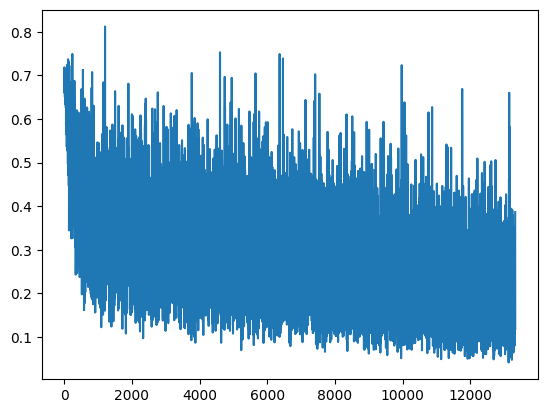

In [107]:
  plt.plot(results['Arabic'][0])

In [ ]:
  plt.plot(results['Bengali'][0])

In [ ]:
  plt.plot(results['Indonesian'][0])

In [115]:
labels = [val_dataset[x][2] for x in range(len(val_dataset))]


In [117]:
total_sum = sum(labels)
total_sum

951

In [118]:
len(val_dataset)

1902